# ATSC 507 Assignment X - Due Mar 12 [Delayed]

In [1]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca' 

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from mpl_toolkits.axes_grid1 import make_axes_locatable
% matplotlib inline

In [3]:
sp.init_printing()

In [4]:
def search_stable(A):
    '''
    Get the indeices of all stable amplitude factor.
    '''
    N = np.size(A, 0)
    index = np.ones(N)*-99 
    for i in range(N):
        if (A[i, :].max()-1 <= 1e-15):
            index[i] = i
        index[index==-99]=np.nan
    return index

#Content
1. [**3p. centered in time, 5p. centered in space**](#3p.-centered-in-time,-5p.-centered-in-space)
2. [**WRF-ARW version of 3rd order Runge-Kutta, 3p centered in space**](#WRF-ARW-version-of-3rd-order-Runge-Kutta,-3p-centered-in-space)

# 3p. centered in time, 5p. centered in space

## Analytical soutions of amplification factor

Apply the scheme to 1D advection equation with constant advection speed ($u_0$):

$$
    \frac{1}{2\Delta t}\left[T_{j, n+1}-T_{j, n-1}\right] = - \frac{u_0}{12\Delta x}\left[ T_{j-2,n} - 8T_{j-1,n} + 8T_{j+1, n} - T_{j+2, n} \right] 
$$

Dividing the both sides with $T_{j,n}$, and define *Courant number* $C = u_0\frac{\Delta t}{\Delta x}$:

$$
    T_{0, 1}-T_{0, -1} = - \frac{C}{6}\left[ T_{-2, 0} - 8T_{-1, 0} + 8T_{1, 0} - T_{2, 0} \right]
$$

For $T_{j, n}$ in a wave-like solution (eigenmode):

$$
    T_{j, n} = [A]^n\exp\left[ik\left(j\Delta x\right)\right]
$$

Substituding $T_{j, n}$ into the equation, we get:

$$
    A - \frac1A + \frac{C}6\left[ - (\exp(2ik\Delta x) - \exp(-2ik\Delta x)) +  8\exp(ik\Delta x) - 8\exp(-ik\Delta x) \right] = 0
$$

Substitude in Euler formular, we have:

$$
    A - \frac1A + \frac{C}{3}[8\sin(k\Delta x)i - 2\sin(k\Delta x)\cos(k\Delta x)i] = 0
$$

And in order to make things easier, I applied *non-dimensional spatial step* $X = k\Delta x$.

For von Neumann instability analysis, we solving this equation respect to $A$, and looking for $C$ solves $|A| \leq 1$ for any $X = k\Delta x$ .



In [5]:
A =sp.symbols('A') # symbols
C, X = sp.symbols('C, X', real=True)
#equ = A - 1/A + C/6*(sp.exp(-2*X*sp.I)-8*sp.exp(-1*X*sp.I)+8*sp.exp(X*sp.I)-sp.exp(2*X*sp.I))
equ = A - 1/A + C/3*(8*sp.sin(X)*sp.I - 2*sp.sin(X)*sp.cos(X)*sp.I)
result = sp.solve(equ, A) # A1 = result[0]; A2 = result[1]

We expected 2 roots for this quadratic equation in the form of:

$$
    A_1 = \frac{-b+\sqrt{b^2-4ac}}{2a} \qquad\ A_2 = \frac{-b-\sqrt{b^2-4ac}}{2a}
$$

**Root I** for $A_1$:

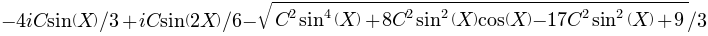

In [6]:
sp.simplify(result[0].expand(trig=True))

For $A_1$, the third term under square root can be both real and imagnary, if it is **real**, I can prove it always equals to 1 (and I use the expression for $A^2$):

In [7]:
equ_A1=(-4*C*sp.sin(X)/3 + C*sp.sin(2*X)/6)**2 + \
(-1*sp.sqrt(C**2*sp.sin(X)**4 + 8*C**2*sp.sin(X)**2*sp.cos(X) - 17*C**2*sp.sin(X)**2 + 9)/3)**2
equ_A1.expand(trig=True)

We know that:
    
$$
    \sin^2(X)\sin^2(X) + \sin^2(X)\cos^2(X) = \sin^2(X)
$$

so we see:

In [8]:
sp.simplify(equ_A1.expand(trig=True))

And the folllowing numerical test will show that, the **stable** case belongs to the "**real** case" hear.

We see similar things for **Root II** & $A_2$:

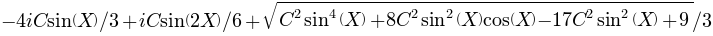

In [9]:
sp.simplify(result[1].expand(trig=True))

In [10]:
equ_A1=(-4*C*sp.sin(X)/3 + C*sp.sin(2*X)/6)**2 + \
(sp.sqrt(C**2*sp.sin(X)**4 + 8*C**2*sp.sin(X)**2*sp.cos(X) - 17*C**2*sp.sin(X)**2 + 9)/3)**2
sp.simplify(equ_A1.expand(trig=True))

## Exploring amplification factors with numerics

*Warner p69* states that, this scheme is stable when $C \leq 0.729$, so here I substituding $C\ \epsilon\ [0.5, 1.0]$  and $k\Delta x\ \epsilon\ [0.5, 3]$ and do the following things:
* Plot amplification factors in a frame of Courant numbers and $k\Delta x$.
* Verify `Warner`'s answer in a certain toleratence of accuracy.
* Find the amount of damping for different Courant number and $k\Delta x$ 

In [11]:
NUM1 = 200
NUM2 = 200
C_num = np.linspace(0.5, 1.0, NUM1)
X_num = np.linspace(0.5, 3, NUM2)
x, c = np.meshgrid(X_num, C_num)

In [12]:
num_result1 = np.empty([NUM1, NUM2]) + 1j*np.empty([NUM1, NUM2])
num_result2 = np.empty([NUM1, NUM2]) + 1j*np.empty([NUM1, NUM2])
for i in range(NUM1):
    for m in range(NUM2):
        num_result1[i, m] = result[0].evalf(subs={X:x[i, m], C:c[i, m]})
        num_result2[i, m] = result[1].evalf(subs={X:x[i, m], C:c[i, m]})
num_result1 = np.abs(num_result1)
num_result2 = np.abs(num_result2)

<matplotlib.colorbar.Colorbar instance at 0x7f4a7a919320>

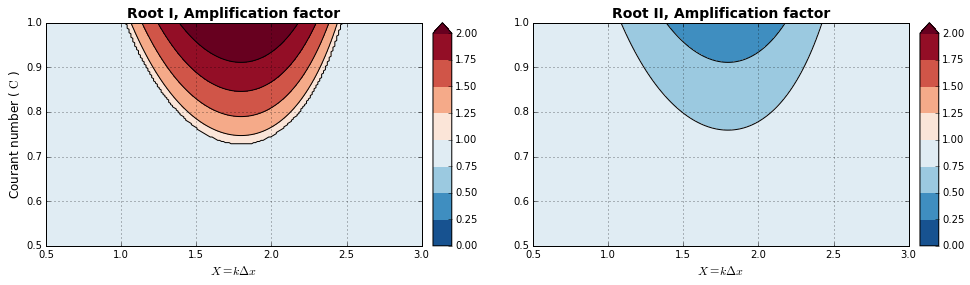

In [13]:
Alev = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5,  1.75, 2]

fig = plt.figure(figsize=(16, 4))

ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
divider1 = make_axes_locatable(ax1); cax1 = divider1.append_axes("right", "5%", pad="3%")
divider2 = make_axes_locatable(ax2); cax2 = divider2.append_axes("right", "5%", pad="3%")

CS1 = ax1.contourf(x, c, num_result1, Alev, cmap=plt.cm.RdBu_r, extend='max')
ax1.contour(x, c, num_result1, Alev, colors=('k', ), linewidths=1)
ax1.set_xlabel('$X = k\Delta x$', fontsize=12); ax1.grid()
ax1.set_ylabel('Courant number ( $\mathrm{C}$ )', fontsize=12); plt.colorbar(CS1, cax=cax1)
ax1.set_title('Root I, Amplification factor', fontsize=14, fontweight='bold')

CS2 = ax2.contourf(x, c, num_result2, Alev, cmap=plt.cm.RdBu_r, extend='max')
ax2.contour(x, c, num_result2, Alev, colors=('k', ), linewidths=1)
ax2.set_xlabel('$X = k\Delta x$', fontsize=12); ax2.grid()
ax2.set_title('Root II, Amplification factor', fontsize=14, fontweight='bold')
plt.colorbar(CS2, cax=cax2)

Based on the amplification factor $|A|$ for 2 roots:

* For small Courant number regime, we see $|A| \leq 1$ for any $k\Delta x$ with no significant damping, which agrees with *Warner p69*:
> "These centered-in-space and centered-in-time schemes, ... do not damp for any stable value of the Courant number."

* For big Courant number regime, root I shows unstable $A$, and root II shows significant damping.

* Root I has a more strict requirement for Courant number, and thus **Root I been satisfied means the whole system is stable**.

## Searching Courant numbers for stable system 

Since we have highlighted the importance of Root I, so here we only need to satisfy Root I. 

In [14]:
index1 = search_stable(num_result1)
index2 = search_stable(num_result2)
bad_kdx1 = X_num[num_result1[np.nanmax(index1)+1, :]>1]
bad_A1 = num_result1[np.nanmax(index1)+1, num_result1[np.nanmax(index1)+1, :]>1]
bad_kdx1 = bad_kdx1[bad_A1==bad_A1.max()]
bad_A1 = bad_A1[bad_A1==bad_A1.max()]

In [15]:
print('Criteria of Courant number: C <= {}'.format(C_num[np.nanmax(index1)]))
print('The most unstable kdx: {}'.format(bad_kdx1))

Criteria of Courant number: C <= 0.72864321608
The most unstable kdx: [ 1.79396985]


We see $C \leq 0.729$ agrees with *Warner p69*.

## Check the amounty of damping

Plot amplification factors against Courant number for $C\ \epsilon\ [0.5, 1.0]$ to see the amount of damping:

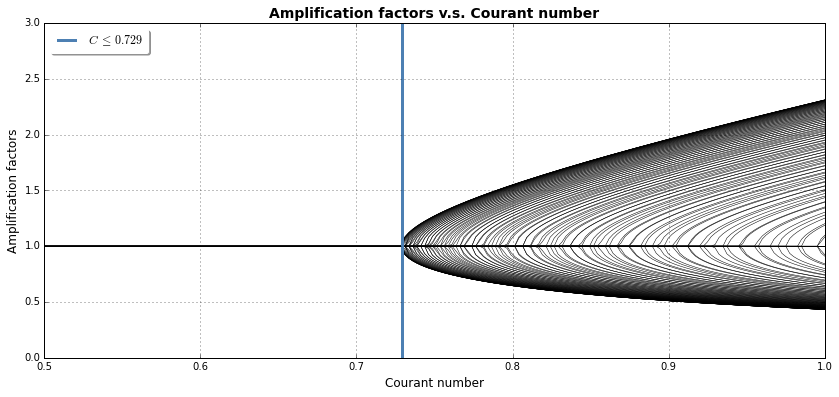

In [16]:
fig = plt.figure(figsize = (14, 6))
ax = fig.gca()
ax.plot(C_num, num_result1, 'k-', linewidth=0.5)
ax.plot(C_num, num_result2, 'k-', linewidth=0.5)
ax.plot([0.729, 0.729], [0, 3], color=[0.3, 0.5, 0.7], linewidth=3, label='$C\ \leq\ 0.729$')
legend=ax.legend(shadow=True, fancybox=True, loc=2, fontsize=12); 
frame=legend.get_frame(); frame.set_color('white'); ax.set_xlim(0.5, 1); ax.grid() 
ax.set_title('Amplification factors v.s. Courant number', fontsize=14, fontweight='bold')
ax.set_xlabel('Courant number', fontsize=12); ax.set_ylabel('Amplification factors', fontsize=12)

Check some of the amplification factors in stable case (according to the figure above, and analytical analysis, they are 1.0). 

In [17]:
num_result1[~np.isnan(index1), :]

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

Thus, no damping for $C \leq 0.729$.

##A quick summary

* We find Courant number $C \leq 0.729$ makes all $k\Delta x$ **stable** and **no damping**. (In the scope of $k\Delta x\ \epsilon\ [0.5, 3]$).
* The answer in *Warner p69* has been verified.
* One of the most unstable wave is $k\Delta x = 1.794$, and there will be more (periodically) for larger $k\Delta x$ since we are play with sin & cos.

# WRF-ARW version of 3rd order Runge-Kutta, 3p centered in space

## Analytical soutions of amplification factor

3rd Runge-Kutta applied in WRF-ARW is:

$$
\begin{align}
T_j^*  &= T_{j, n} + \frac{\Delta t}{3} f(T_{j, n}) \\
T_j^{**}  &= T_{j, n} + \frac{\Delta t}{2} f(T_j^*) \\
T_{j, n+1}  &= T_{j, n} + \Delta t \ f(T_j^{**}) \\
\end{align}
$$

Apply that scheme into 1D advection equation (as section 1 did), with a discretization of 3 points centered in space, we have:

$$
\begin{align}
T_j^*  &= T_{j, n} + \frac{\Delta t}{3}\left[-u_0\frac{T_{j+1, n}-T_{j-1, n}}{2\Delta x}\right] \\
T_j^{**}  &= T_{j, n} + \frac{\Delta t}{2} \left[-u_0\frac{T_{j+1, n}^*-T_{j-1, n}^*}{2\Delta x}\right] \\
T_{j, n+1}  &= T_{j, n} + \Delta t \ \left[-u_0\frac{T_{j+1, n}^{**}-T_{j-1, n}^{**}}{2\Delta x}\right] \\
\end{align}
$$

Simplified the equations above with *Courant number* $C = u_0\frac{\Delta t}{\Delta x}$:

$$
\begin{align}
T_j^*  &= T_{j, n} + \frac{\Delta t}{3}\left[-u_0\frac{T_{j+1, n}-T_{j-1, n}}{2\Delta x}\right] \\
T_{j, n+1}  &= T_{j, n} + \frac{C}{2}\left[ T_{j+1, n}-T_{j-1, n}-\frac{C}{4}T_{j+2, n}^* + \frac{C}{2}T_{j, n}^* - \frac{C}{4}T_{j-2, n}^*\right] \\
\end{align}
$$

Then:

$$
T_{j, n+1} = \left[ \left(1-\frac{C^2}{4}\right)T_j - \left(\frac{C}{2}-\frac{C^3}{16}\right)\left(T_{j+1}-T_{j-1}\right)+\left(\frac{C^2}{8}\right)\left(T_{j+2}+T_{j-2}\right)-\left(\frac{C^3}{48}\left(T_{j+3}-T_{j-3}\right)\right)  \right]_n
$$

Dividing the both sides with $T_{j,n}$:

$$
T_{0, 1} = \left[ \left(1-\frac{C^2}{4}\right)T_0 - \left(\frac{C}{2}-\frac{C^3}{16}\right)\left(T_{1}-T_{-1}\right)+\left(\frac{C^2}{8}\right)\left(T_{2}+T_{-2}\right)-\left(\frac{C^3}{48}\right)\left(T_{3}-T_{-3}\right)  \right]_n
$$

Substituding the eigenmode $T_{j, n} = [A]^n\exp\left[iXj\right]$, $\left(X=k\Delta x\right)$, we get an expression for $A$:

$$
A = \left(1-\frac{C^2}{4}\right)-\left(\frac{C}{2}-\frac{C^3}{16}\right)\left(e^{Xi}-e^{-Xi}\right)+\left(\frac{C^2}{8}\right)\left(e^{2Xi}+e^{-2Xi}\right)-\left(\frac{C^3}{48}\right)\left(e^{3Xi}-e^{-3Xi}\right)
$$

Considering Euler's formula $e^{ix} = \cos x + i\sin x$, the magnitude of $A$ is:

$$
|A| = \sqrt{\left(\frac{C^{3}}{24} \sin{\left (3 X \right )} + \left(- \frac{C^{3}}{8} + C\right) \sin{\left (X \right )}\right)^{2} + \left(\frac{C^{2}}{4} \cos{\left (2 X \right )} - \frac{C^{2}}{4} + 1\right)^{2}}
$$

In [18]:
A, C, X =sp.symbols('A, C, X')
orig = sp.sqrt(((1-C**2/4)+(C**2/4)*sp.cos(2*X))**2 + (-(C-C**3/8)*sp.sin(X)-(C**3/24)*sp.sin(3*X))**2)

Substitude in trigonometric identities, and collecting terms.

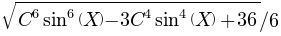

In [19]:
result = sp.simplify(orig.expand(trig=True))
result

We use this expression for von Neumann instability analysis.

## Exploring amplification factor with numerics

As HW10.B required, here I substituding $C\ \epsilon\ [0.1, 3]$ and $k\Delta x\ \epsilon\ [2, 20]$, and then do the following things:
* Plot amplification factors in a frame of Courant numbers and $X=k\Delta x$.
* Find the worst case(s) with corresponds $X$.
* Find the critical value of Courant number.

In [20]:
NUM1 = 400
NUM2 = 400
C_num = np.linspace(0.1, 3.0, NUM1)
X_num = np.linspace(0, 20, NUM2)
x, c = np.meshgrid(X_num, C_num)
select_x = np.array([2, 2.5, 3, 4, 5, 10, 20])
x1, c1 = np.meshgrid(select_x, C_num)

In [21]:
num_result = np.empty([NUM1, NUM2]) + 1j*np.empty([NUM1, NUM2])
select_result = np.empty([NUM1, len(select_x)]) + 1j*np.empty([NUM1, len(select_x)])
for i in range(NUM1):
    for m in range(NUM2):
        num_result[i, m] = result.evalf(subs={X:x[i, m], C:c[i, m]})
    for n in range(len(select_x)):
        select_result[i, n] = result.evalf(subs={X:x1[i, n], C:c1[i, n]})
num_result = np.abs(num_result)
select_result = np.abs(select_result)

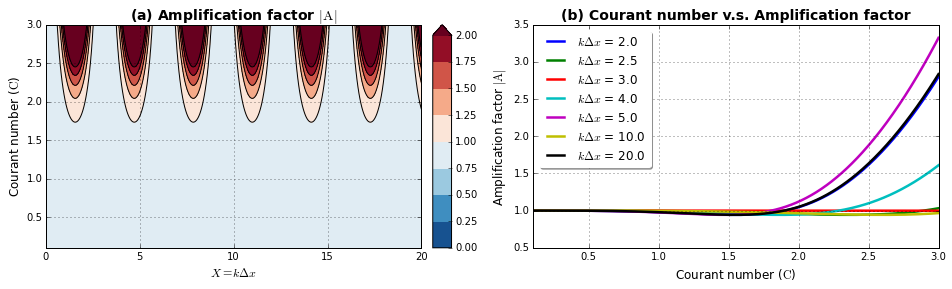

In [22]:
Alev = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

fig = plt.figure(figsize=(16, 4))

ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
divider1 = make_axes_locatable(ax1); cax1 = divider1.append_axes("right", "5%", pad="3%")

CS1 = ax1.contourf(x, c, num_result, Alev, cmap=plt.cm.RdBu_r, extend='max')
ax1.contour(x, c, num_result, Alev, colors=('k', ), linewidths=1)
ax1.set_xlabel('$X = k\Delta x$', fontsize=12); ax1.grid()
ax1.set_ylabel('Courant number ($\mathrm{C}$)', fontsize=12); plt.colorbar(CS1, cax=cax1)
ax1.set_title('(a) Amplification factor $\mathrm{|A|}$', fontsize=14, fontweight='bold')

for i in range(len(select_x)):
    ax2.plot(C_num, select_result[:,i], linewidth=2.5, label='$k\Delta x$ = '+str(select_x[i]))
legend=ax2.legend(shadow=True, fancybox=True, loc=2, fontsize=12); 
frame=legend.get_frame(); frame.set_color('white') 
ax2.grid(); ax2.set_xlim(0.1, 3.0)
ax2.set_xlabel('Courant number ($\mathrm{C}$)', fontsize=12)
ax2.set_ylabel('Amplification factor $\mathrm{|A|}$', fontsize=12)
ax2.set_title('(b) Courant number v.s. Amplification factor', fontweight='bold', fontsize=14)

In [23]:
index = search_stable(num_result)
bad_kdx = X_num[num_result[np.nanmax(index)+1, :]>1]
bad_A = num_result[np.nanmax(index)+1, num_result[np.nanmax(index)+1, :]>1]

In [24]:
print('Criteria of Courant number: C <= {}'.format(C_num[np.nanmax(index)]))
print('The most unstable kdx: {}'.format(bad_kdx))

Criteria of Courant number: C <= 1.72807017544
The most unstable kdx: [  1.55388471   1.60401003   4.66165414   4.71177945   4.76190476
   7.81954887   7.86967419  10.97744361  11.02756892  14.08521303
  14.13533835  14.18546366  17.24310777  17.29323308]


We see the most unstable waves distribute like: ~1.5, ~4.7, ~7.8, ~11, ~14.1, 17.3. And 'link' these numbers with $\pi$ (we are playing with sin & cos), we will find:

In [25]:
print(np.pi/2*np.array([1, 3, 5, 7, 9, 11]))

[  1.57079633   4.71238898   7.85398163  10.99557429  14.13716694
  17.27875959]


So the most unstable waves could be:
$$
k\Delta x = n\frac{\pi}{2}, \quad\ n=1, 3, 5, 7, 9, 11, \ldots
$$

##A quick summary

* For WRF-ARW version of 3rd order Runge-Kutta, 3p centered in space. We find Courant number $C \leq 1.728$ makes all $k\Delta x$ stable. 
* The most unstable set of $k\Delta x$ could be:
$$
k\Delta x = n\frac{\pi}{2}, \quad\ n=1, 3, 5, 7, 9, \ldots
$$ 
* According to "courant number v.s. Amplification factor" plot, we see unstable $|A|$ for large Courant number; and we also see damping for all $k\Delta x$, especially $C\ \epsilon\ [1, 1.728]$ for stable Courant number. The damping is smaller than 0.25, so it cannot be identified from contours in Fig.a.

** Comparing with the higher-order stability criteria in *WRF-ARW tech. note***:

Combining the result above with the results in the 'tech. note', we see:

 <table style="width:70%", align="left">
  <tr>
    <td>Time scheme</td>
    <td>2nd spacial</td>
    <td>3rd spacial</td>
    <td>4th spacial</td>
    <td>5th spacial</td>
    <td>6th spacial</td>
  </tr>
  <tr>
    <td>R.-K. 3rd order</td>
    <td>**1.728**</td>
    <td>1.61</td>
    <td>1.26</td>
    <td>1.42</td>
    <td>1.08</td>
  </tr>
</table> 

We find that 2nd order centered difference in space has the most flexible choice of Courant number, it allows bigger timesteps.